In [1]:
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import re
import pickle

In [2]:
def get_R(path, initial_infected, final_round):
    """
    Find the time when there is new infection and total number of newly infected people after the final round
    """
    
    file_list = glob(path)
    num_of_new_infected_people = []
    new_infected_time = []

    for file in file_list:
        df = pd.read_csv(file)
        df = df.groupby('round')['isSick'].sum()
        
        num_of_new_infected_people.append(df[final_round])
        
        # Bineary Search to find the first occurance of value >= intial_infected + 1
        left, right = 0, 99
        
        while(left < right - 1):
            mid = left + int((right - left)/2)
            mid_value = df[mid]
            if mid_value >= initial_infected + 1:
                right = mid
            else:
                left = mid
        
        # post processing
        if df[left] >= initial_infected + 1:
            new_infected_time.append(left);
        elif df[right] >= initial_infected + 1:
            new_infected_time.append(right);
        else:
            new_infected_time.append(110)
        
    return num_of_new_infected_people, new_infected_time

In [3]:
def snapShot(df, title, affected_area_ordinate_list, save_path=None):
    """
    Visualize the snapshot of people distribution in the space
    """
    
    fig = plt.figure(figsize=(10, 10))
    ax = plt.gca()

    # Draw a circle on the matrix
    for ordinate in affected_area_ordinate_list:
        circle = plt.Circle(ordinate, 0.5, color='r', alpha = 0.1)
        ax.add_artist(circle)
    
    # Draw square on (0,0)
    square = plt.Rectangle((-0.5, -0.5), 1,1, angle=0.0, color='g', alpha = 0.1)
    ax.add_artist(square)
        
    ax.set_aspect(1.0) # make aspect ratio square

    _ = plt.xlim([-0.5, 9.5])
    _ = plt.ylim([-0.5, 9.5])
    plt.xticks(np.arange(10), size=20)
    plt.yticks(np.arange(10), size=20)

    # plot the scatter plot
    plt.scatter(x=df['row'],
                y=df['col'],
                s=500,
                c=df['color'],
                alpha = 0.5)
    plt.text(1, 0.5, 'Entrance/Exit', horizontalalignment='center', verticalalignment='center', size=20)
    plt.text(8, 9.7, 'Total Infected: {}'.format(df['isSick'].sum()), horizontalalignment='center', verticalalignment='center', size=20, color = 'r')
    
    plt.title(title, size=20)
    plt.xlabel("Col", size=20)
    plt.ylabel('Row', size=20)

    plt.grid()
    
    if save_path:
        plt.savefig(save_path)
        plt.close(fig)

def scatter_plot(dict_distribution_list, color_list, xticks_range, yticks_range, title, x_title, y_title, label_list = None):
    """
    Scatter plot y vs. x
    """
    fig = plt.figure(figsize=(10, 10))
    if not label_list:
        for dict_distribution, color in zip(dict_distribution_list, color_list):
            plt.plot(list(dict_distribution.keys()), list(dict_distribution.values()), '{}o-'.format(color), markersize=12)
    else:
        for dict_distribution, color, label in zip(dict_distribution_list, color_list, label_list):
            plt.plot(list(dict_distribution.keys()), list(dict_distribution.values()), '{}o-'.format(color), markersize=12, label=label)
            plt.legend(loc="best", fontsize='x-large')
        
    plt.xticks(xticks_range, size=20)
    plt.yticks(yticks_range, size=20)
    plt.title(title, size=20)
    plt.xlabel(x_title, size=20)
    plt.ylabel(y_title, size=20)
    plt.show()

# 1. No mask
People do not wear masks during shopping

### 1.1 Number of People in the Market
1000 repeated simulations for each scenario with 10, 20, 50, 80, 100 people in 3600 sq feet market respectively

In [4]:
# For each scenario, get the the median number of first new infection and total newly infected people
num_of_new_infected_people_distribution = dict()
new_infected_time_distribution = dict()

for i in (10, 20, 50, 80, 100):
    num_of_new_infected_people, new_infected_time = get_R('unmask/numOfPeople/{}/*.csv'.format(i), 1, 99)
    num_of_new_infected_people_distribution[i] = np.median(num_of_new_infected_people) - 1  
    new_infected_time_distribution[i] = np.median(new_infected_time)  

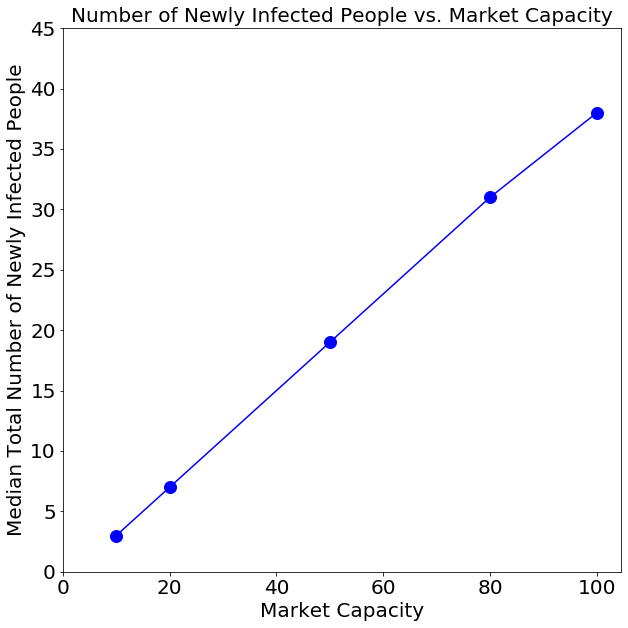

In [5]:
# Median value of newly infected people
scatter_plot([num_of_new_infected_people_distribution], color_list=['b'], xticks_range=np.arange(0, 101, 20), yticks_range=np.arange(0, 46, 5), title="Number of Newly Infected People vs. Market Capacity", x_title="Market Capacity", y_title="Median Total Number of Newly Infected People")

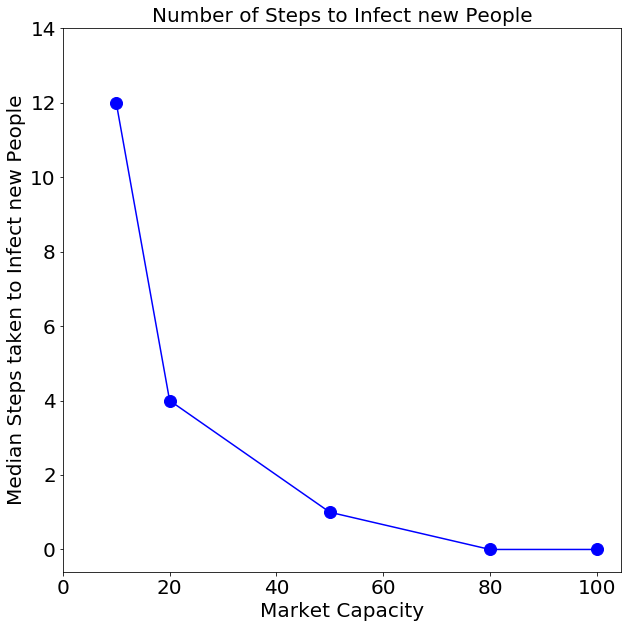

In [6]:
# Minimum steps needed for new infection
scatter_plot([new_infected_time_distribution], color_list=['b'], xticks_range=np.arange(0, 101, 20), yticks_range=np.arange(0, 16, 2), title="Number of Steps to Infect new People", x_title="Market Capacity", y_title="Median Steps taken to Infect new People")

In [7]:
# Save the first simulation of 50 people with 1 patient
df = pd.read_csv('unmask/numOfPeople/50/output0.csv')

affected_area_ordinate = df.loc[0,  ['row','col']].tolist()

df['color'] = df['isSick'].map(lambda x: 'red' if x else 'green')

for i in range(100):
    df_round = df[df['round']==i]
    snapShot(df_round, title='Round {}'.format(i), save_path='unmask/numOfPeople/movie50/{}.jpg'.format(i), affected_area_ordinate_list=[affected_area_ordinate])

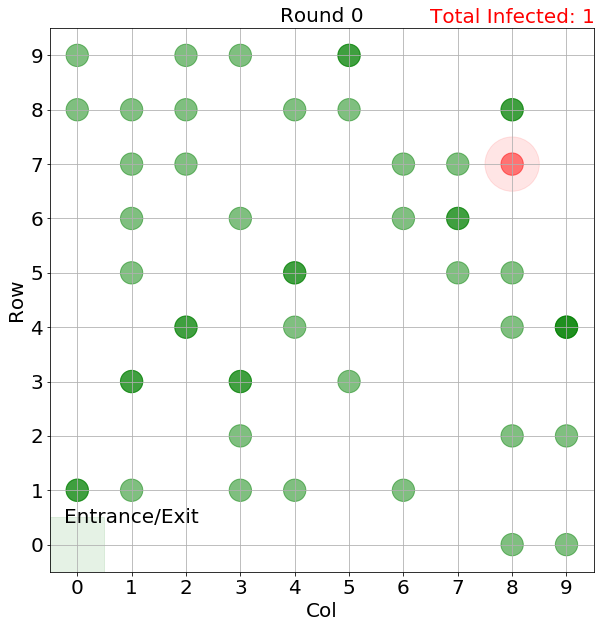

In [8]:
# Distribution of 50 people at start
df_round = df[df['round']==0]
snapShot(df_round, title='Round 0', affected_area_ordinate_list=[affected_area_ordinate])

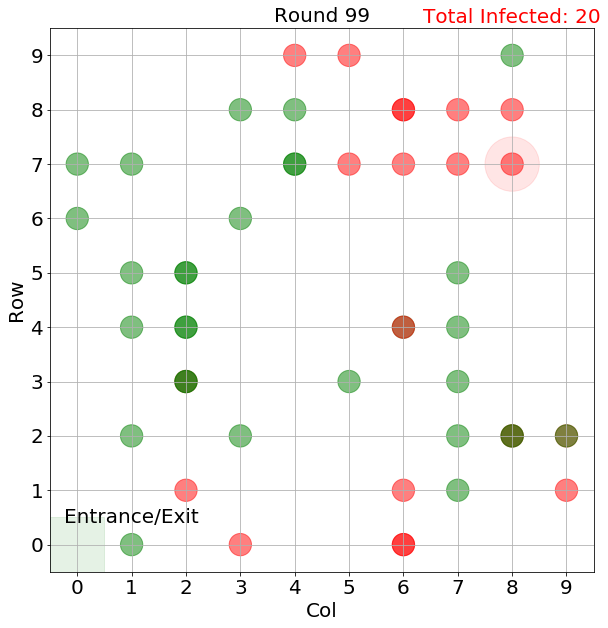

In [9]:
# Distribution of 50 people at the end
df_round = df[df['round']==99]
snapShot(df_round, title='Round 99', affected_area_ordinate_list=[affected_area_ordinate])

### 1.2 Number of people infected at T0
1000 repeated simulations for each scenario with the number of people initially infected at 1, 2, 4, 6, 8, 10, 15, 20 (Number of total people in the market is 50)

In [10]:
num_of_new_infected_people_distribution_initial = dict()
new_infected_time_distribution_initial = dict()

for i in (1, 2, 4, 6, 8, 10, 15, 20):
    num_of_new_infected_people, new_infected_time = get_R('unmask/numOfSickPeople/{}/*.csv'.format(i), i, 99)
    num_of_new_infected_people_distribution_initial[i] = np.median(num_of_new_infected_people) - i
    new_infected_time_distribution_initial[i] = np.median(new_infected_time)  

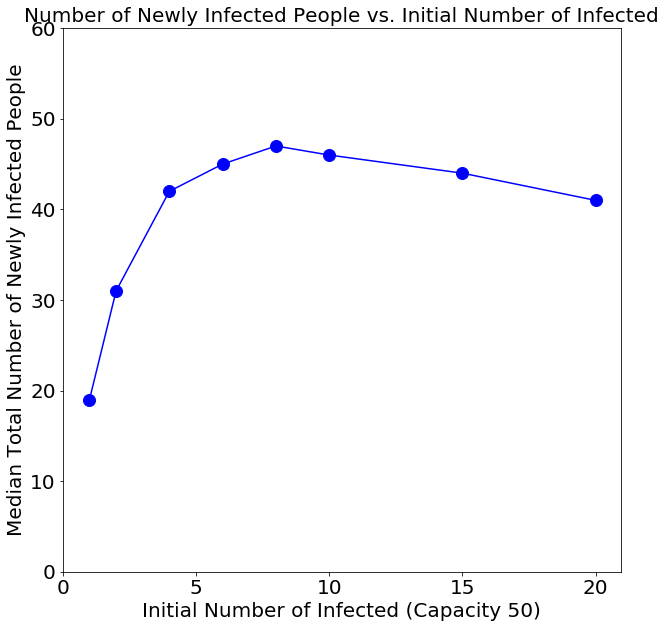

In [11]:
scatter_plot([num_of_new_infected_people_distribution_initial], color_list=['b'], xticks_range=np.arange(0, 21, 5), yticks_range=np.arange(0, 70, 10), title="Number of Newly Infected People vs. Initial Number of Infected", x_title="Initial Number of Infected (Capacity 50)", y_title="Median Total Number of Newly Infected People")

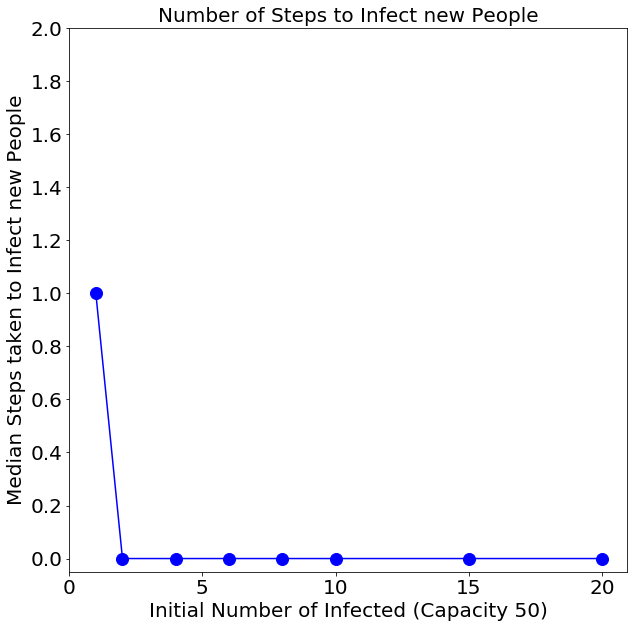

In [12]:
scatter_plot([new_infected_time_distribution_initial], color_list=['b'], xticks_range=np.arange(0, 21, 5), yticks_range=np.arange(0, 2.1, 0.2), title="Number of Steps to Infect new People", x_title="Initial Number of Infected (Capacity 50)", y_title="Median Steps taken to Infect new People")

In [13]:
# Save the first simulation of 50 people with 4 initial infected people
df = pd.read_csv('unmask/numOfSickPeople/4/output0.csv')

df_temp = df[df['round'] == 0]
df_temp = df_temp[df_temp['id'] < 4][['row', 'col']]
affected_area_ordinate_list = list(zip(df_temp['row'], df_temp['col']))

df['color'] = df['isSick'].map(lambda x: 'red' if x else 'green')

for i in range(100):
    df_round = df[df['round']==i]
    snapShot(df_round, title='Round {}'.format(i), save_path='unmask/numOfSickPeople/movie4/{}.jpg'.format(i), affected_area_ordinate_list=affected_area_ordinate_list)

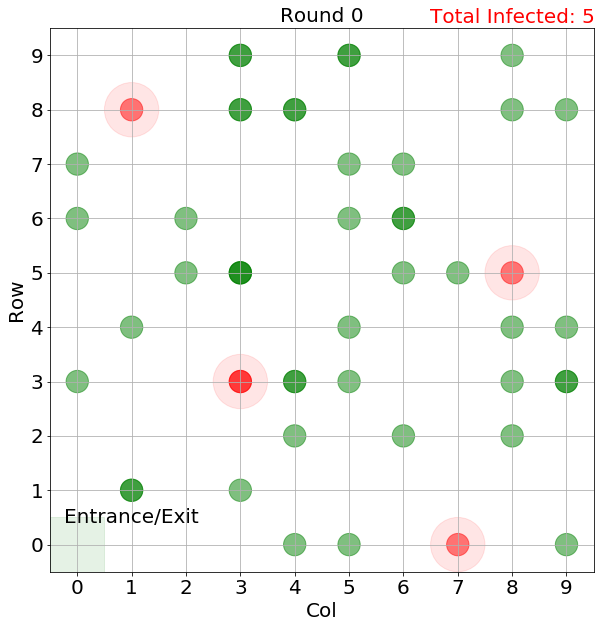

In [14]:
# Distribution of 50 people at the beginning
df_round = df[df['round']==0]
snapShot(df_round, title='Round 0', affected_area_ordinate_list=affected_area_ordinate_list)

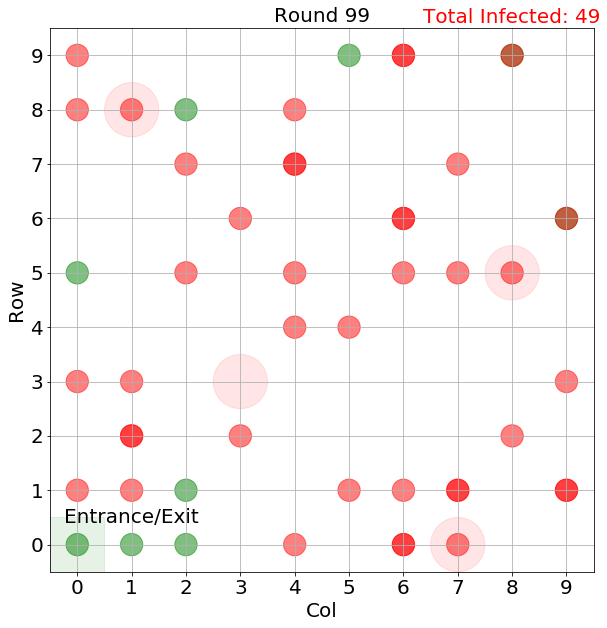

In [15]:
# Distribution of 50 people at the end
df_round = df[df['round']==99]
snapShot(df_round, title='Round 99', affected_area_ordinate_list=affected_area_ordinate_list)

# 2. Partially Wearing Masks
There are two groups of people in the market with similar size:
1. Wearing masks (Probability of getting sick 20%)
2. Not wearing masks (Protection of getting sick 100%)

### 2.1 Number of People in the Market
1000 repeated simulations for each scenario with 10, 20, 50, 80, 100 persons in 3600 sq feet market respectively

In [16]:
num_of_new_infected_people_distribution_partial_mask = dict()
new_infected_time_distribution_partial_mask = dict()

for i in (10, 20, 50, 80, 100):
    num_of_new_infected_people, new_infected_time = get_R('partialmask/numOfPeople/{}/*.csv'.format(i), 1, 99)
    num_of_new_infected_people_distribution_partial_mask[i] = np.median(num_of_new_infected_people) - 1   
    new_infected_time_distribution_partial_mask[i] = np.median(new_infected_time)

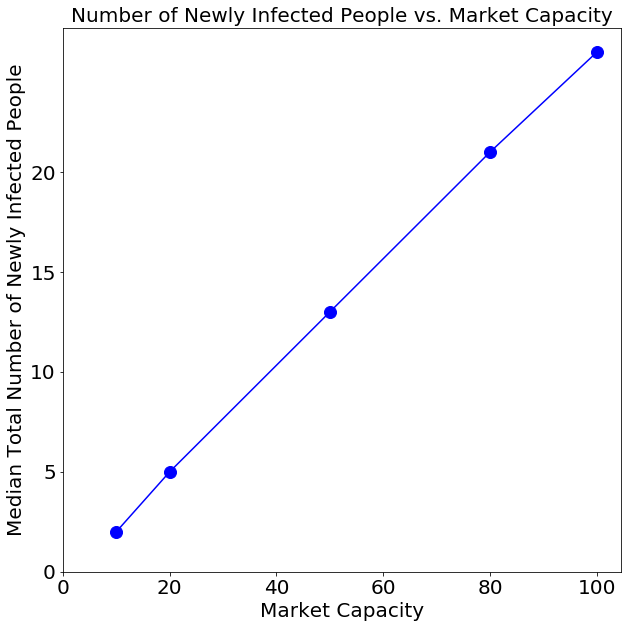

In [17]:
scatter_plot([num_of_new_infected_people_distribution_partial_mask], color_list=['b'], xticks_range=np.arange(0, 101, 20), yticks_range=np.arange(0, 25, 5),  title="Number of Newly Infected People vs. Market Capacity", x_title="Market Capacity", y_title="Median Total Number of Newly Infected People")

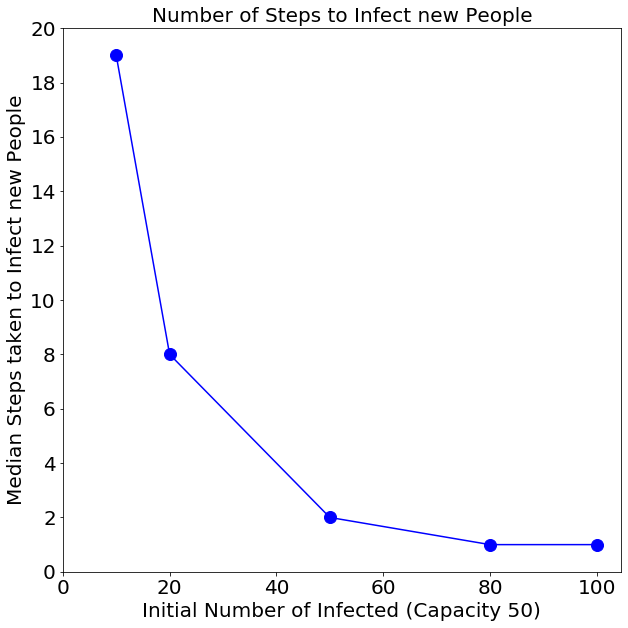

In [18]:
scatter_plot([new_infected_time_distribution_partial_mask], color_list=['b'], xticks_range=np.arange(0, 101, 20), yticks_range=np.arange(0, 21, 2), title="Number of Steps to Infect new People", x_title="Initial Number of Infected (Capacity 50)", y_title="Median Steps taken to Infect new People")

In [19]:
df = pd.read_csv('partialmask/numOfPeople/50/output0.csv')

affected_area_ordinate = df.loc[0,  ['row','col']].tolist()

df['color'] = df['isSick'].map(lambda x: 'red' if x else 'green')

for i in range(100):
    df_round = df[df['round']==i]
    snapShot(df_round, title='Round {}'.format(i), save_path='partialmask/numOfPeople/movie50/{}.jpg'.format(i), affected_area_ordinate_list=[affected_area_ordinate])

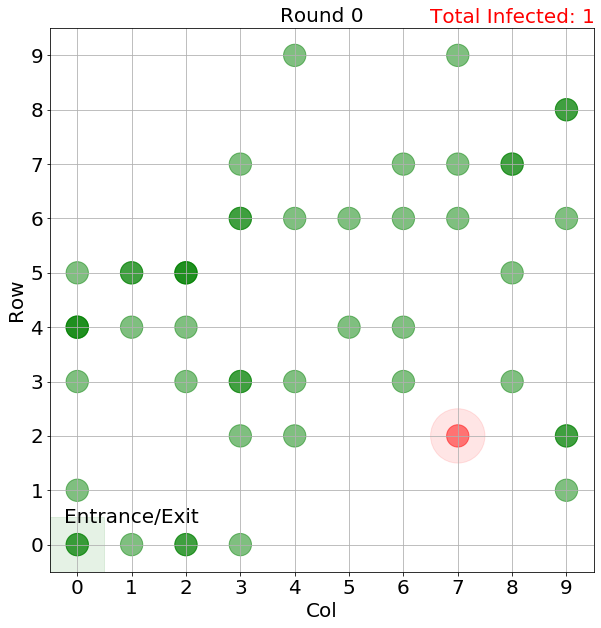

In [20]:
df_round = df[df['round']==0]
snapShot(df_round, title='Round 0', affected_area_ordinate_list=[affected_area_ordinate])

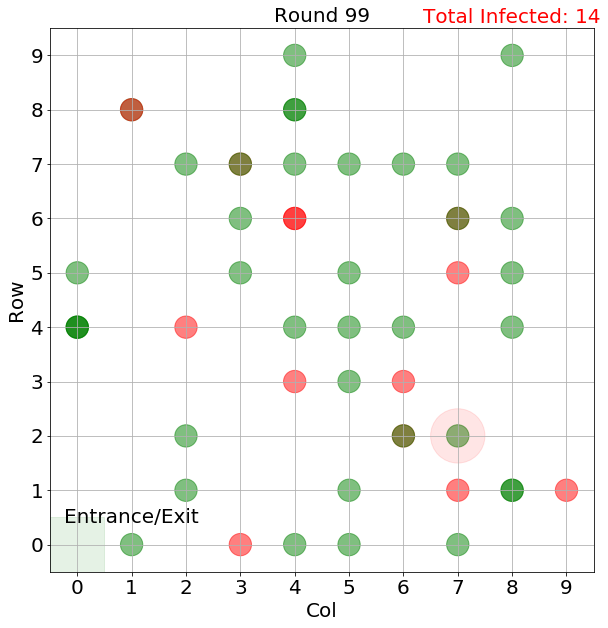

In [21]:
df_round = df[df['round']==99]
snapShot(df_round, title='Round 99', affected_area_ordinate_list=[affected_area_ordinate])

### 2.2 Number of people infected at T0
1000 repeated simulations for each scenario with the number of people infected at 1, 2, 4, 6, 8, 10, 15, 20 (Number of total people in the market is 50)

In [22]:
num_of_new_infected_people_distribution_initial_partial_mask = dict()
new_infected_time_distribution_initial_partial_mask = dict()

for i in (1, 2, 4, 6, 8, 10, 15, 20):
    num_of_new_infected_people, new_infected_time = get_R('partialmask/numOfSickPeople/{}/*.csv'.format(i), i, 99)
    num_of_new_infected_people_distribution_initial_partial_mask[i] = np.median(num_of_new_infected_people) - i 
    new_infected_time_distribution_initial_partial_mask[i] = np.median(new_infected_time)

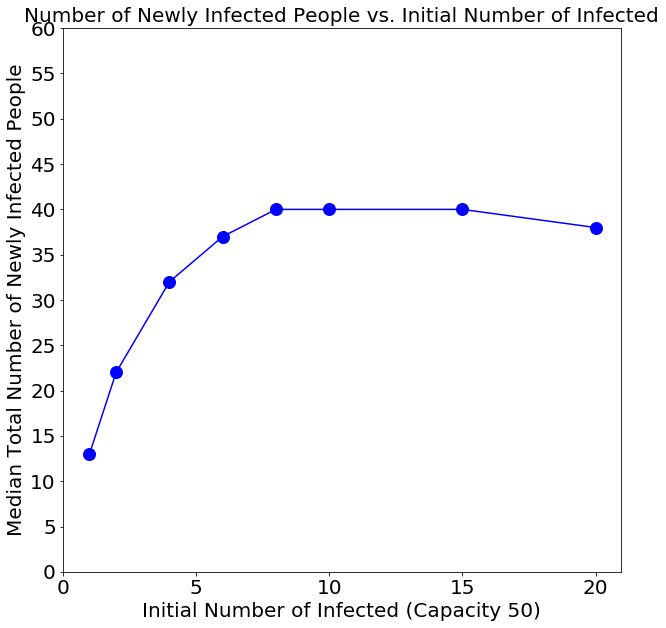

In [23]:
scatter_plot([num_of_new_infected_people_distribution_initial_partial_mask], color_list=['b'], xticks_range=np.arange(0, 21, 5), yticks_range=np.arange(0, 61, 5), title="Number of Newly Infected People vs. Initial Number of Infected", x_title="Initial Number of Infected (Capacity 50)", y_title="Median Total Number of Newly Infected People")

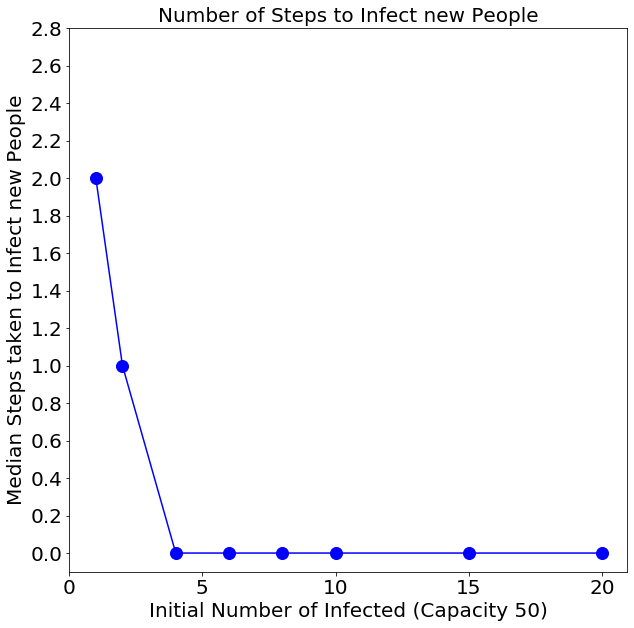

In [24]:
scatter_plot([new_infected_time_distribution_initial_partial_mask], color_list=['b'], xticks_range=np.arange(0, 21, 5), yticks_range=np.arange(0, 3, 0.2), title="Number of Steps to Infect new People", x_title="Initial Number of Infected (Capacity 50)", y_title="Median Steps taken to Infect new People")

In [25]:
df = pd.read_csv('partialmask/numOfSickPeople/4/output0.csv')

df_temp = df[df['round'] == 0]
df_temp = df_temp[df_temp['id'] < 4][['row', 'col']]
affected_area_ordinate_list = list(zip(df_temp['row'], df_temp['col']))

df['color'] = df['isSick'].map(lambda x: 'red' if x else 'green')

for i in range(100):
    df_round = df[df['round']==i]
    snapShot(df_round, title='Round {}'.format(i), save_path='partialmask/numOfSickPeople/movie4/{}.jpg'.format(i), affected_area_ordinate_list=affected_area_ordinate_list)

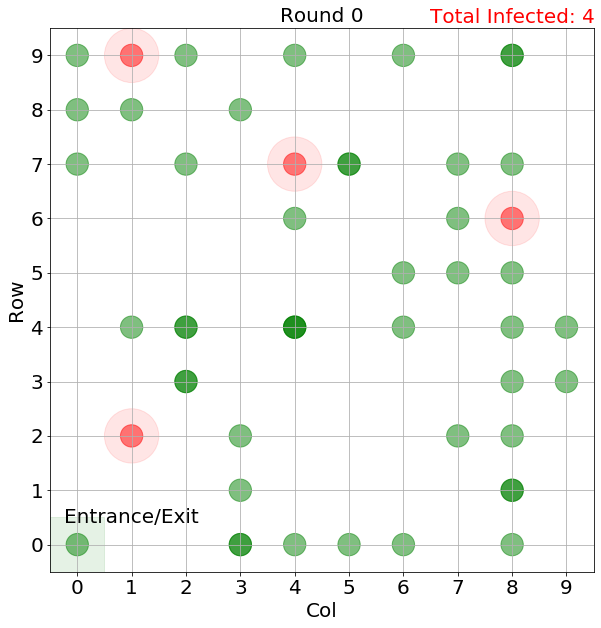

In [26]:
df_round = df[df['round']==0]
snapShot(df_round, title='Round 0', affected_area_ordinate_list=affected_area_ordinate_list)

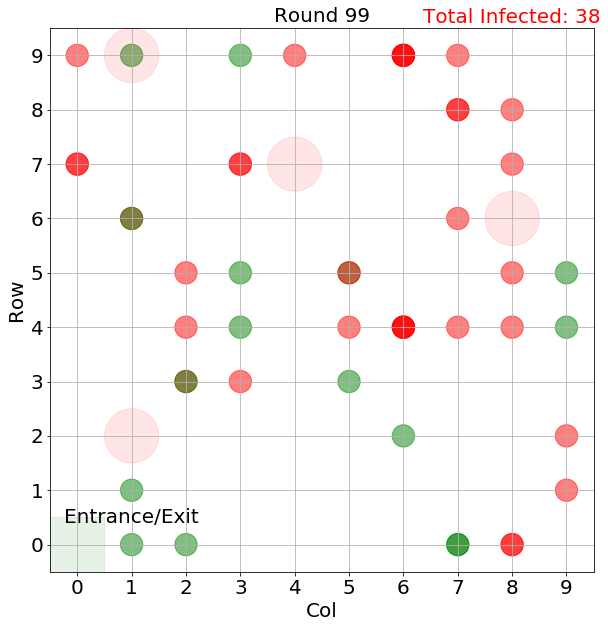

In [27]:
df_round = df[df['round']==99]
snapShot(df_round, title='Round 99', affected_area_ordinate_list=affected_area_ordinate_list)

# 3. All Wearing Masks

All people are wearing masks with probability of getting sick 20%

### 3.1 Number of People in the Market
1000 repeated simulations for each scenario with 10, 20, 50, 80, 100 persons in 3600 sq feet market respectively

In [28]:
num_of_new_infected_people_distribution_all_mask = dict()
new_infected_time_distribution_all_mask = dict()

for i in (10, 20, 50, 80, 100):
    num_of_new_infected_people, new_infected_time = get_R('allmask/numOfPeople/{}/*.csv'.format(i), 1, 99)
    num_of_new_infected_people_distribution_all_mask[i] = np.median(num_of_new_infected_people) - 1
    new_infected_time_distribution_all_mask[i] = np.median(new_infected_time)

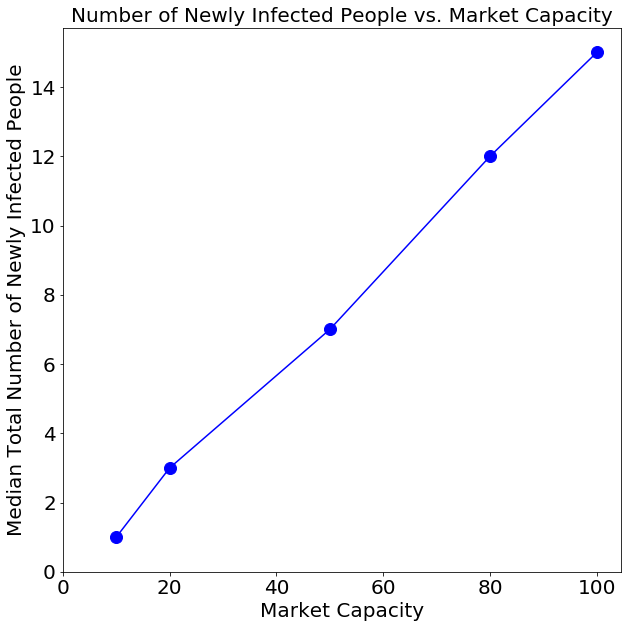

In [29]:
scatter_plot([num_of_new_infected_people_distribution_all_mask], color_list=['b'], xticks_range=np.arange(0, 101, 20), yticks_range=np.arange(0, 15, 2),  title="Number of Newly Infected People vs. Market Capacity", x_title="Market Capacity", y_title="Median Total Number of Newly Infected People")

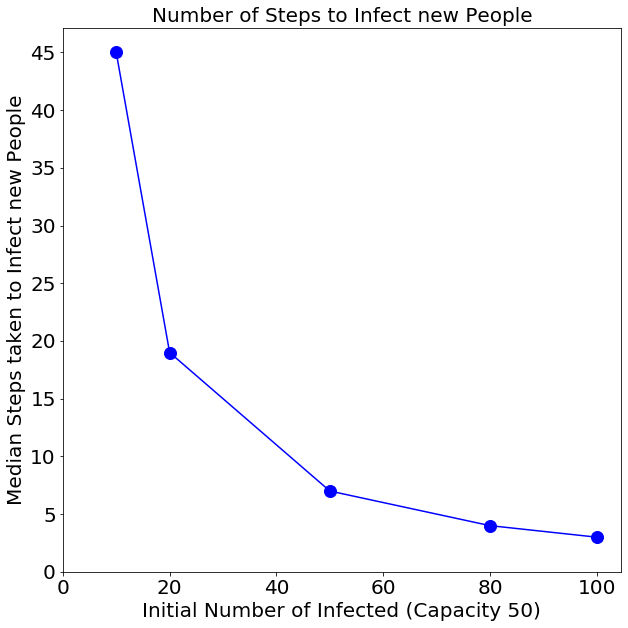

In [30]:
scatter_plot([new_infected_time_distribution_all_mask], color_list=['b'], xticks_range=np.arange(0, 101, 20), yticks_range=np.arange(0, 50, 5), title="Number of Steps to Infect new People", x_title="Initial Number of Infected (Capacity 50)", y_title="Median Steps taken to Infect new People")

In [31]:
# Save the first simulation of 50 people with 1 patient
df = pd.read_csv('allmask/numOfPeople/50/output0.csv')

affected_area_ordinate = df.loc[0,  ['row','col']].tolist()

df['color'] = df['isSick'].map(lambda x: 'red' if x else 'green')

for i in range(100):
    df_round = df[df['round']==i]
    snapShot(df_round, title='Round {}'.format(i), save_path='allmask/numOfPeople/movie50/{}.jpg'.format(i), affected_area_ordinate_list=[affected_area_ordinate])

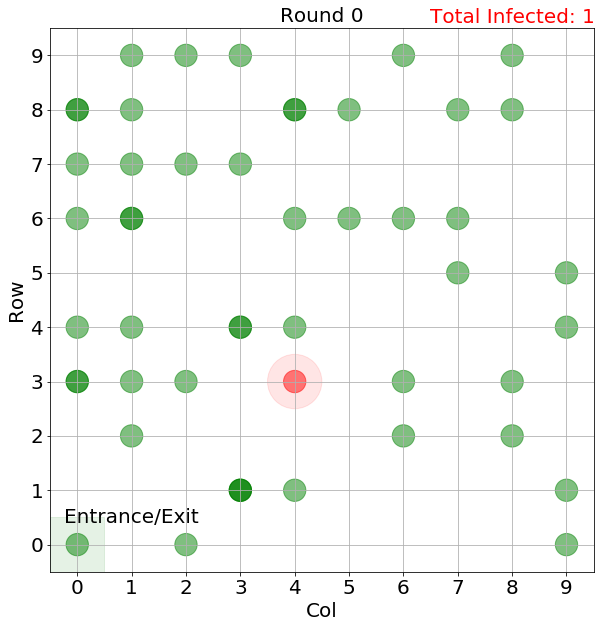

In [32]:
df_round = df[df['round']==0]
snapShot(df_round, title='Round 0', affected_area_ordinate_list=[affected_area_ordinate])

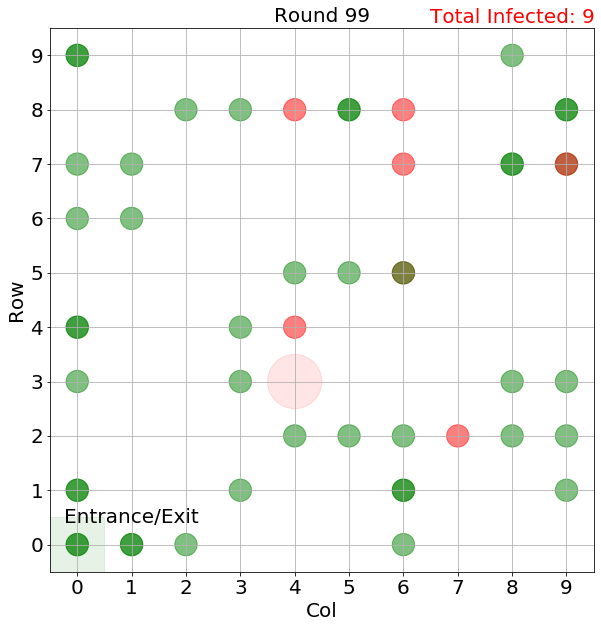

In [33]:
df_round = df[df['round']==99]
snapShot(df_round, title='Round 99', affected_area_ordinate_list=[affected_area_ordinate])

### 3.2 Number of people infected at T0
1000 repeated simulations for each scenario with the number of people infected at 1, 2, 4, 6, 8, 10, 15, 20 (Number of total people in the market is 50)

In [34]:
num_of_new_infected_people_distribution_initial_all_mask = dict()
new_infected_time_distribution_initial_all_mask = dict()

for i in (1, 2, 4, 6, 8, 10, 15, 20):
    num_of_new_infected_people, new_infected_time = get_R('allmask/numOfSickPeople/{}/*.csv'.format(i), i, 99)
    num_of_new_infected_people_distribution_initial_all_mask[i] = np.median(num_of_new_infected_people) - i
    new_infected_time_distribution_initial_all_mask[i] = np.median(new_infected_time)

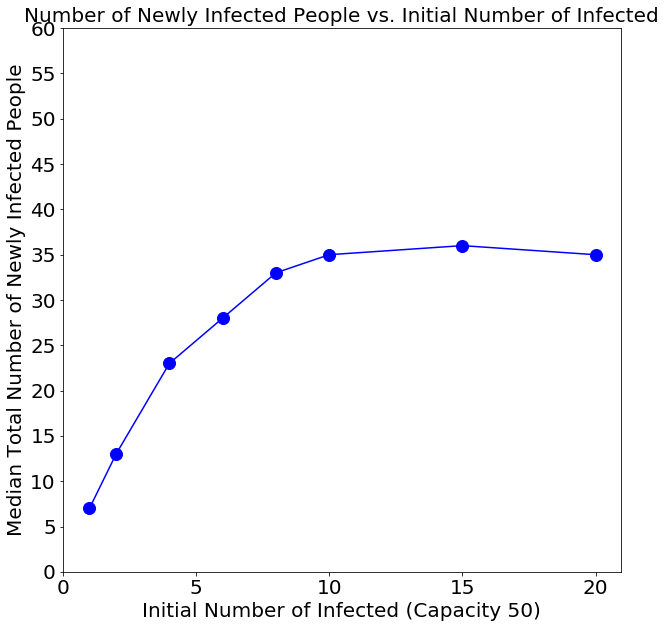

In [35]:
scatter_plot([num_of_new_infected_people_distribution_initial_all_mask], color_list=['b'], xticks_range=np.arange(0, 21, 5), yticks_range=np.arange(0, 61, 5), title="Number of Newly Infected People vs. Initial Number of Infected", x_title="Initial Number of Infected (Capacity 50)", y_title="Median Total Number of Newly Infected People")

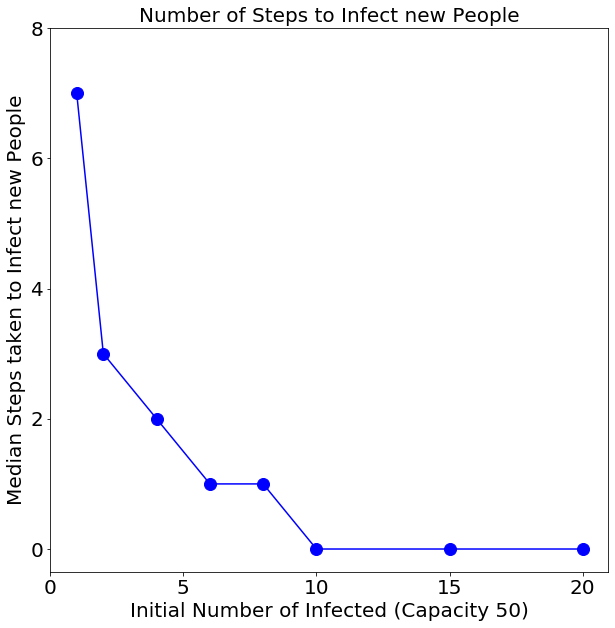

In [36]:
scatter_plot([new_infected_time_distribution_initial_all_mask], color_list=['b'], xticks_range=np.arange(0, 21, 5), yticks_range=np.arange(0, 10, 2), title="Number of Steps to Infect new People", x_title="Initial Number of Infected (Capacity 50)", y_title="Median Steps taken to Infect new People")

In [37]:
df = pd.read_csv('allmask/numOfSickPeople/4/output0.csv')

df_temp = df[df['round'] == 0]
df_temp = df_temp[df_temp['id'] < 4][['row', 'col']]
affected_area_ordinate_list = list(zip(df_temp['row'], df_temp['col']))

df['color'] = df['isSick'].map(lambda x: 'red' if x else 'green')

for i in range(100):
    df_round = df[df['round']==i]
    snapShot(df_round, title='Round {}'.format(i), save_path='allmask/numOfSickPeople/movie4/{}.jpg'.format(i), affected_area_ordinate_list=affected_area_ordinate_list)

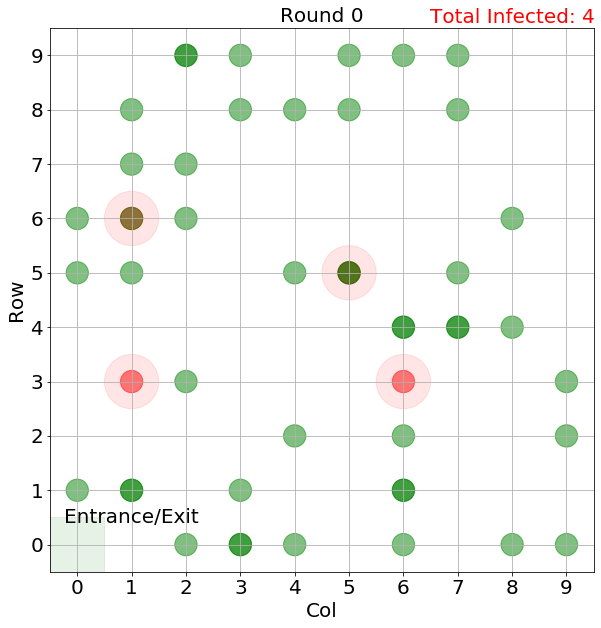

In [38]:
df_round = df[df['round']==0]
snapShot(df_round, title='Round 0', affected_area_ordinate_list=affected_area_ordinate_list)

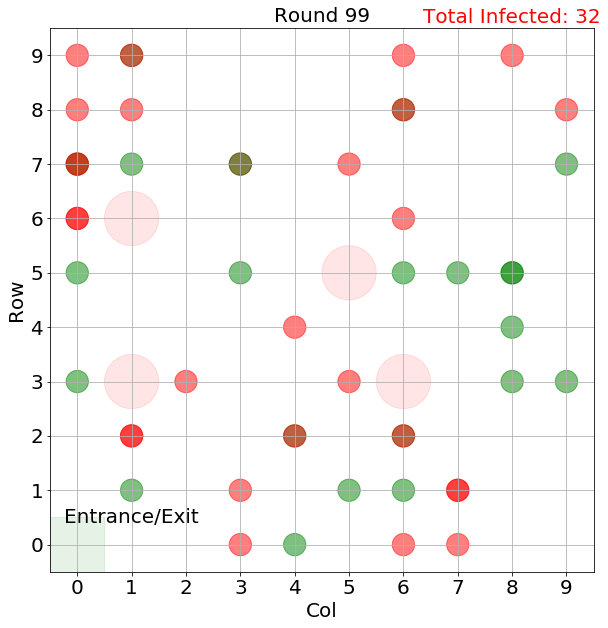

In [39]:
df_round = df[df['round']==99]
snapShot(df_round, title='Round 99', affected_area_ordinate_list=affected_area_ordinate_list)

# 4. All Wearing Masks with probability of getting sick 5%

All people are wearing masks with probability of getting sick 5%

### 4.1 Number of People in the Market
1000 repeated simulations for each scenario with 10, 20, 50, 80, 100 persons in 3600 sq feet market respectively

In [40]:
num_of_new_infected_people_distribution_all_mask_95 = dict()
new_infected_time_distribution_all_mask_95 = dict()

for i in (10, 20, 50, 80, 100):
    num_of_new_infected_people, new_infected_time = get_R('allmask95/numOfPeople/{}/*.csv'.format(i), 1, 99)
    num_of_new_infected_people_distribution_all_mask_95[i] = np.median(num_of_new_infected_people) - 1 
    new_infected_time_distribution_all_mask_95[i] = np.median(new_infected_time)

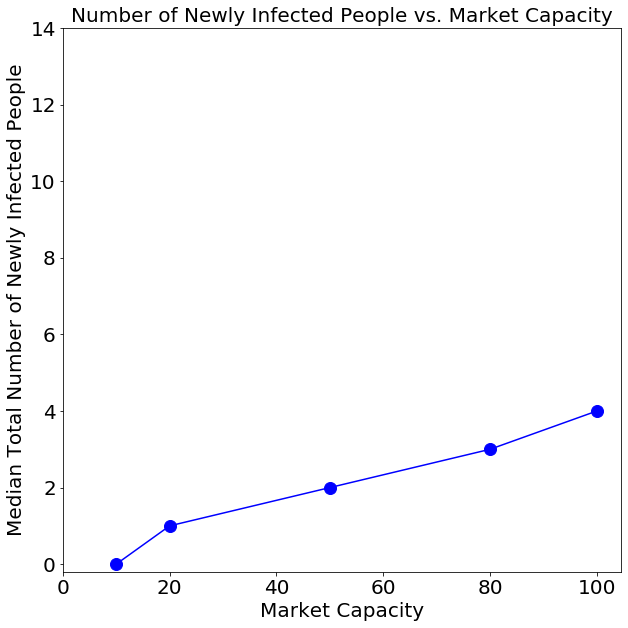

In [41]:
scatter_plot([num_of_new_infected_people_distribution_all_mask_95], color_list=['b'], xticks_range=np.arange(0, 101, 20), yticks_range=np.arange(0, 15, 2),  title="Number of Newly Infected People vs. Market Capacity", x_title="Market Capacity", y_title="Median Total Number of Newly Infected People")

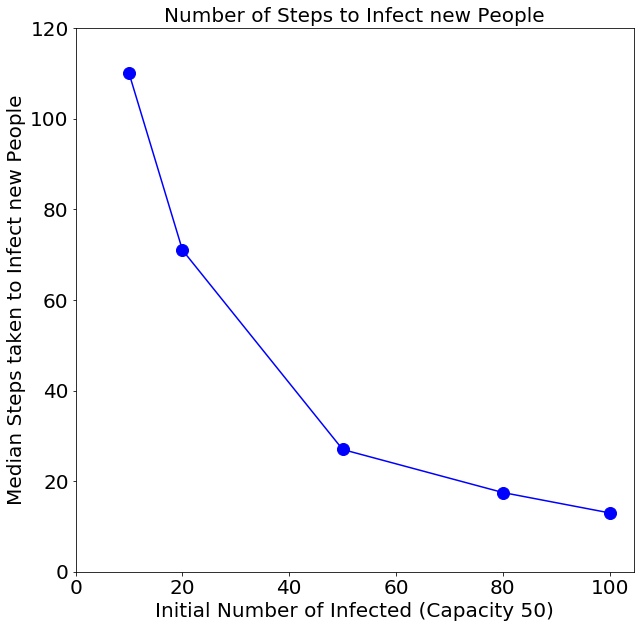

In [42]:
scatter_plot([new_infected_time_distribution_all_mask_95], color_list=['b'], xticks_range=np.arange(0, 101, 20), yticks_range=np.arange(0, 121, 20), title="Number of Steps to Infect new People", x_title="Initial Number of Infected (Capacity 50)", y_title="Median Steps taken to Infect new People")

In [43]:
df = pd.read_csv('allmask95/numOfPeople/50/output0.csv')

affected_area_ordinate = df.loc[0,  ['row','col']].tolist()

df['color'] = df['isSick'].map(lambda x: 'red' if x else 'green')

for i in range(100):
    df_round = df[df['round']==i]
    snapShot(df_round, title='Round {}'.format(i), save_path='allmask95/numOfPeople/movie50/{}.jpg'.format(i), affected_area_ordinate_list=[affected_area_ordinate])

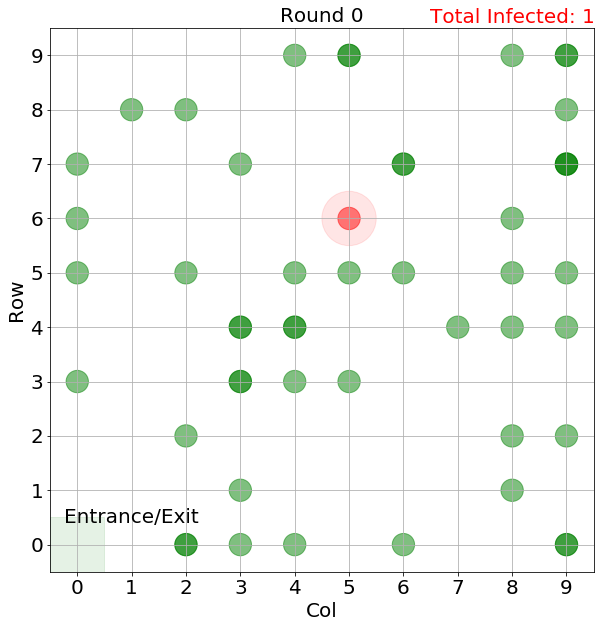

In [44]:
df_round = df[df['round']==0]
snapShot(df_round, title='Round 0', affected_area_ordinate_list=[affected_area_ordinate])

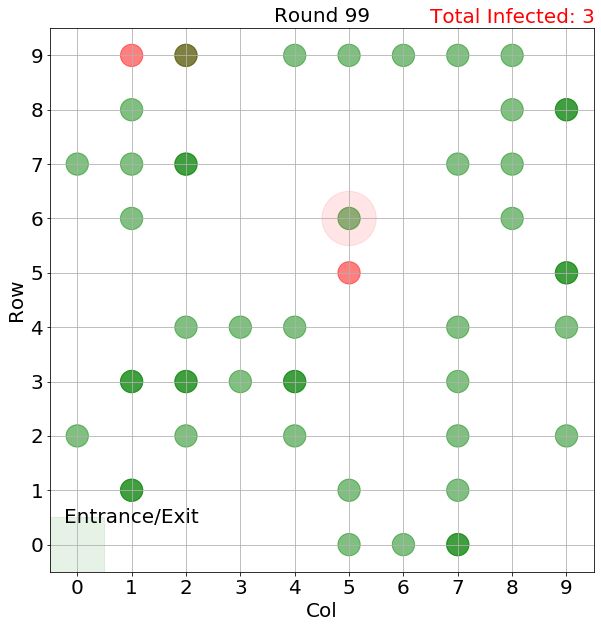

In [45]:
df_round = df[df['round']==99]
snapShot(df_round, title='Round 99', affected_area_ordinate_list=[affected_area_ordinate])

### 4.2 Number of people infected at T0
1000 repeated simulations for each scenario with the number of people infected at 1, 2, 4, 6, 8, 10, 15, 20 (Number of total people in the market is 50)

In [46]:
num_of_new_infected_people_distribution_initial_all_mask_95 = dict()
new_infected_time_distribution_initial_all_mask_95 = dict()

for i in (1, 2, 4, 6, 8, 10, 15, 20):
    num_of_new_infected_people, new_infected_time = get_R('allmask95/numOfSickPeople/{}/*.csv'.format(i), i, 99)
    num_of_new_infected_people_distribution_initial_all_mask_95[i] = np.median(num_of_new_infected_people) - i   
    new_infected_time_distribution_initial_all_mask_95[i] = np.median(new_infected_time)

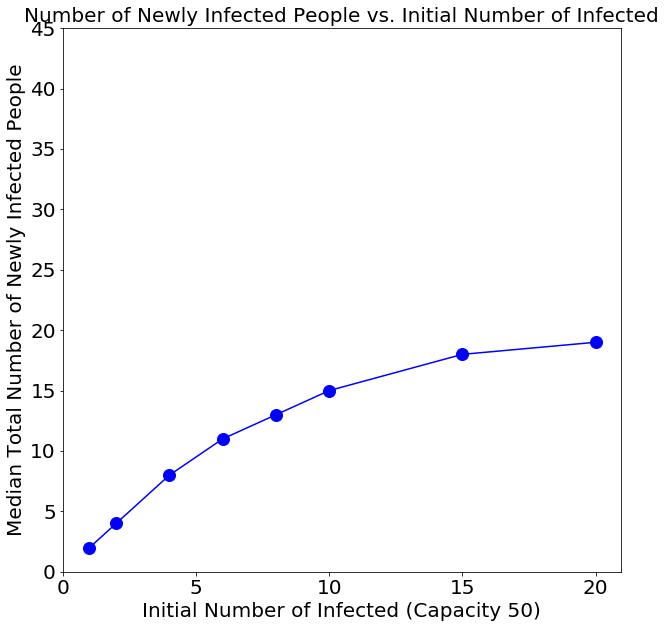

In [47]:
scatter_plot([num_of_new_infected_people_distribution_initial_all_mask_95], color_list=['b'], xticks_range=np.arange(0, 21, 5), yticks_range=np.arange(0, 50, 5), title="Number of Newly Infected People vs. Initial Number of Infected", x_title="Initial Number of Infected (Capacity 50)", y_title="Median Total Number of Newly Infected People")

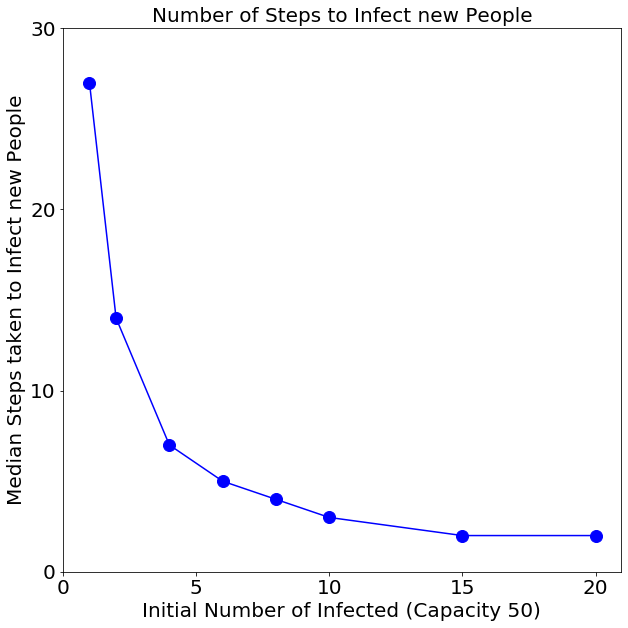

In [48]:
scatter_plot([new_infected_time_distribution_initial_all_mask_95], color_list=['b'], xticks_range=np.arange(0, 21, 5), yticks_range=np.arange(0, 40, 10), title="Number of Steps to Infect new People", x_title="Initial Number of Infected (Capacity 50)", y_title="Median Steps taken to Infect new People")

In [49]:
df = pd.read_csv('allmask95/numOfSickPeople/4/output0.csv')

df_temp = df[df['round'] == 0]
df_temp = df_temp[df_temp['id'] < 4][['row', 'col']]
affected_area_ordinate_list = list(zip(df_temp['row'], df_temp['col']))

df['color'] = df['isSick'].map(lambda x: 'red' if x else 'green')

for i in range(100):
    df_round = df[df['round']==i]
    snapShot(df_round, title='Round {}'.format(i), save_path='allmask95/numOfSickPeople/movie4/{}.jpg'.format(i), affected_area_ordinate_list=affected_area_ordinate_list)

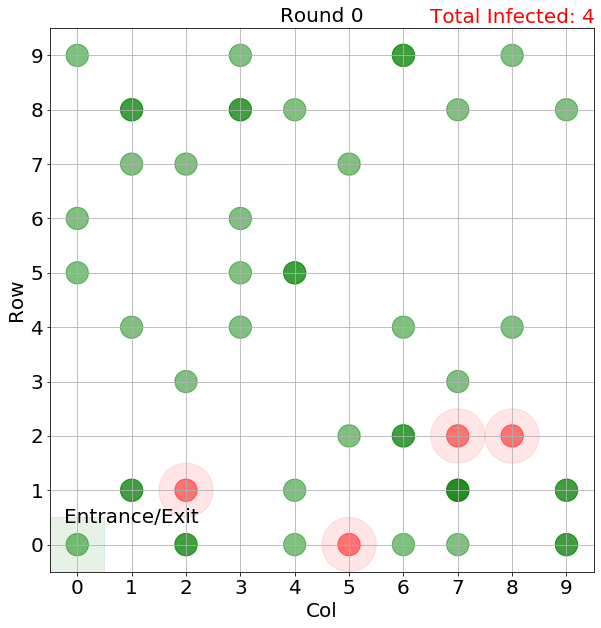

In [50]:
df_round = df[df['round']==0]
snapShot(df_round, title='Round 0', affected_area_ordinate_list=affected_area_ordinate_list)

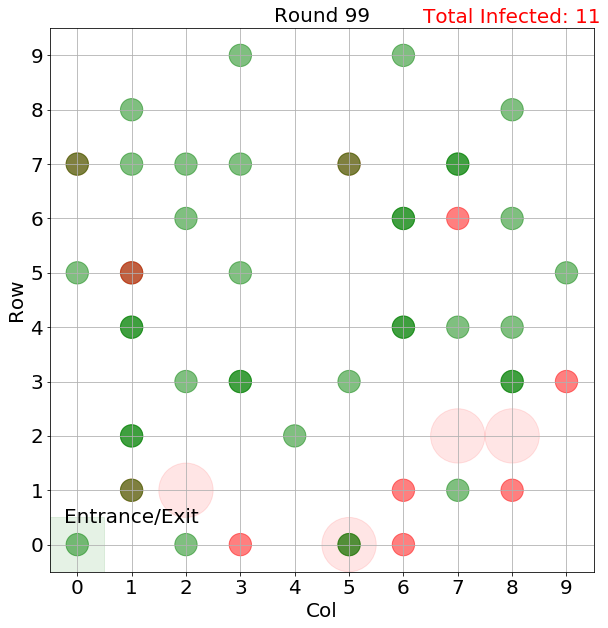

In [51]:
df_round = df[df['round']==99]
snapShot(df_round, title='Round 99', affected_area_ordinate_list=affected_area_ordinate_list)

# 5. All Wearing Masks with probability of getting sick 1%

All people are wearing masks with probability of getting sick 1%

### 4.1 Number of People in the Market
1000 repeated simulations for each scenario with 10, 20, 50, 80, 100 persons in 3600 sq feet market respectively

In [52]:
num_of_new_infected_people_distribution_all_mask_99 = dict()
new_infected_time_distribution_all_mask_99 = dict()

for i in (10, 20, 50, 80, 100):
    num_of_new_infected_people, new_infected_time = get_R('allmask99/numOfPeople/{}/*.csv'.format(i), 1, 99)
    num_of_new_infected_people_distribution_all_mask_99[i] = np.median(num_of_new_infected_people) - 1
    new_infected_time_distribution_all_mask_99[i] = np.median(new_infected_time)

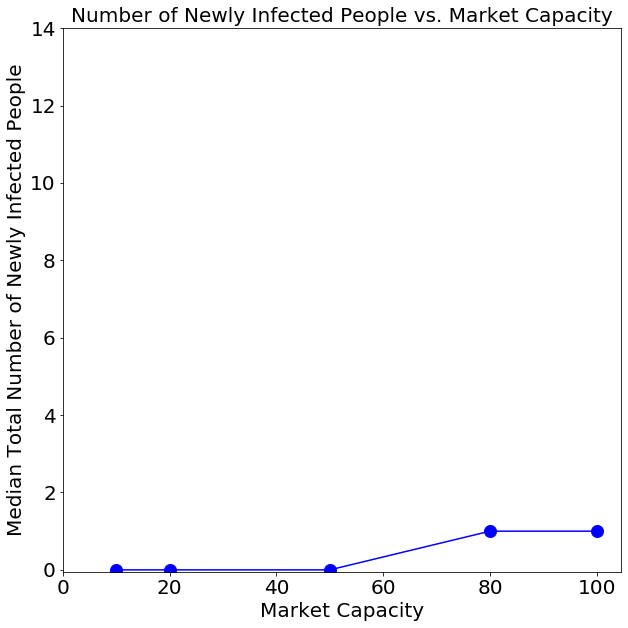

In [53]:
scatter_plot([num_of_new_infected_people_distribution_all_mask_99], color_list=['b'], xticks_range=np.arange(0, 101, 20), yticks_range=np.arange(0, 15, 2),  title="Number of Newly Infected People vs. Market Capacity", x_title="Market Capacity", y_title="Median Total Number of Newly Infected People")

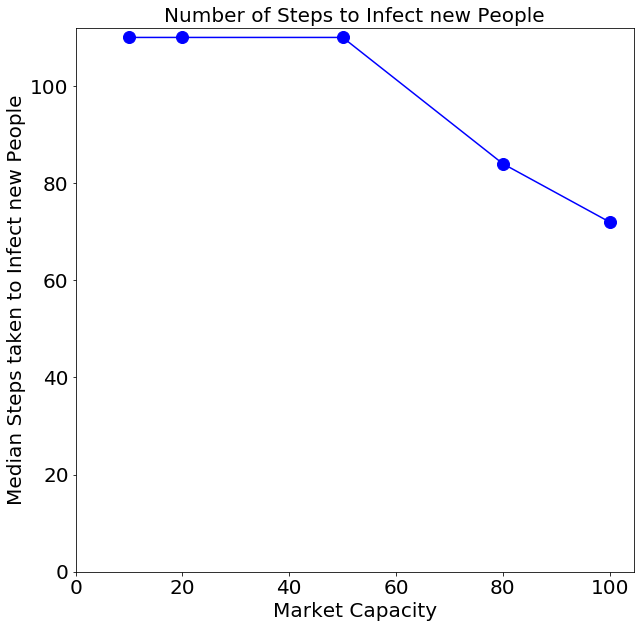

In [54]:
scatter_plot([new_infected_time_distribution_all_mask_99], color_list=['b'], xticks_range=np.arange(0, 101, 20), yticks_range=np.arange(0, 120, 20), title="Number of Steps to Infect new People", x_title="Market Capacity", y_title="Median Steps taken to Infect new People")

In [55]:
df = pd.read_csv('allmask99/numOfPeople/50/output0.csv')

affected_area_ordinate = df.loc[0,  ['row','col']].tolist()

df['color'] = df['isSick'].map(lambda x: 'red' if x else 'green')

for i in range(100):
    df_round = df[df['round']==i]
    snapShot(df_round, title='Round {}'.format(i), save_path='allmask99/numOfPeople/movie50/{}.jpg'.format(i), affected_area_ordinate_list=[affected_area_ordinate])

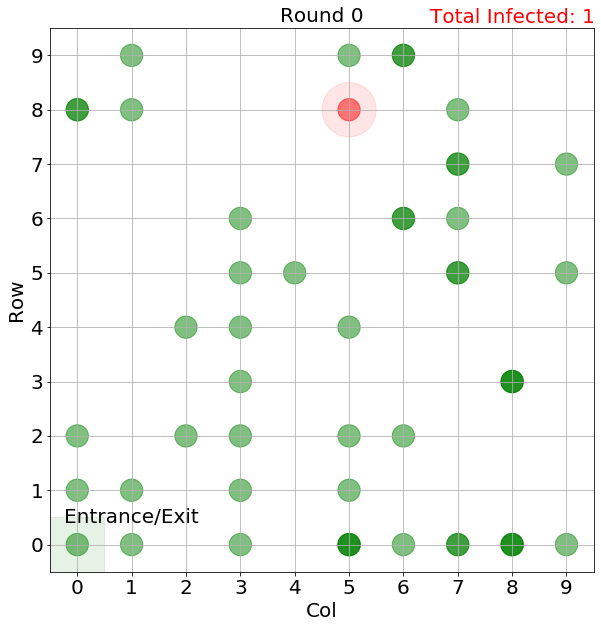

In [56]:
df_round = df[df['round']==0]
snapShot(df_round, title='Round 0', affected_area_ordinate_list=[affected_area_ordinate])

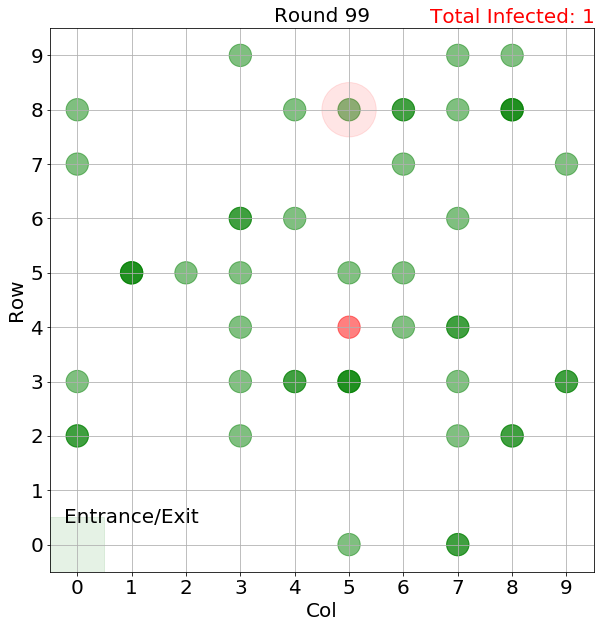

In [57]:
df_round = df[df['round']==99]
snapShot(df_round, title='Round 99', affected_area_ordinate_list=[affected_area_ordinate])

### 5.2 Number of people infected at T0
1000 repeated simulations for each scenario with the number of people infected at 1, 2, 4, 6, 8, 10, 15, 20 (Number of total people in the market is 50)

In [58]:
num_of_new_infected_people_distribution_initial_all_mask_99 = dict()
new_infected_time_distribution_initial_all_mask_99 = dict()

for i in (1, 2, 4, 6, 8, 10, 15, 20):
    num_of_new_infected_people, new_infected_time = get_R('allmask99/numOfSickPeople/{}/*.csv'.format(i), i, 99)
    num_of_new_infected_people_distribution_initial_all_mask_99[i] = np.median(num_of_new_infected_people) - i 
    new_infected_time_distribution_initial_all_mask_99[i] = np.median(new_infected_time)

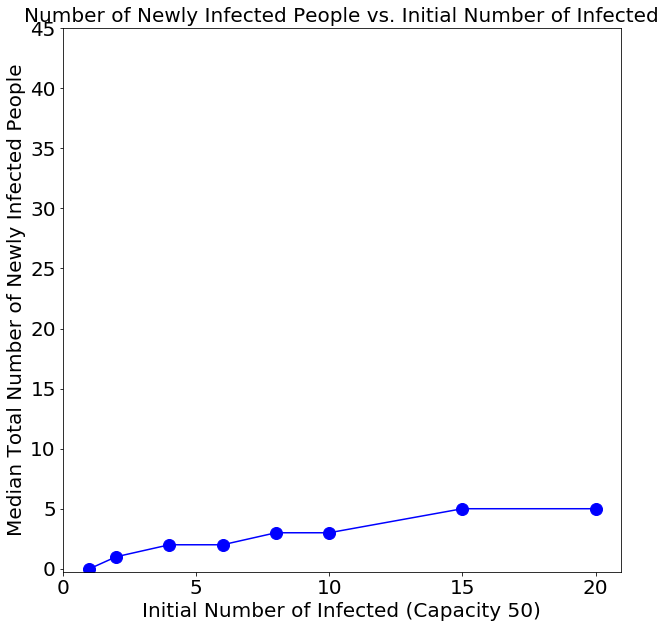

In [59]:
scatter_plot([num_of_new_infected_people_distribution_initial_all_mask_99], color_list=['b'], xticks_range=np.arange(0, 21, 5), yticks_range=np.arange(0, 50, 5), title="Number of Newly Infected People vs. Initial Number of Infected", x_title="Initial Number of Infected (Capacity 50)", y_title="Median Total Number of Newly Infected People")

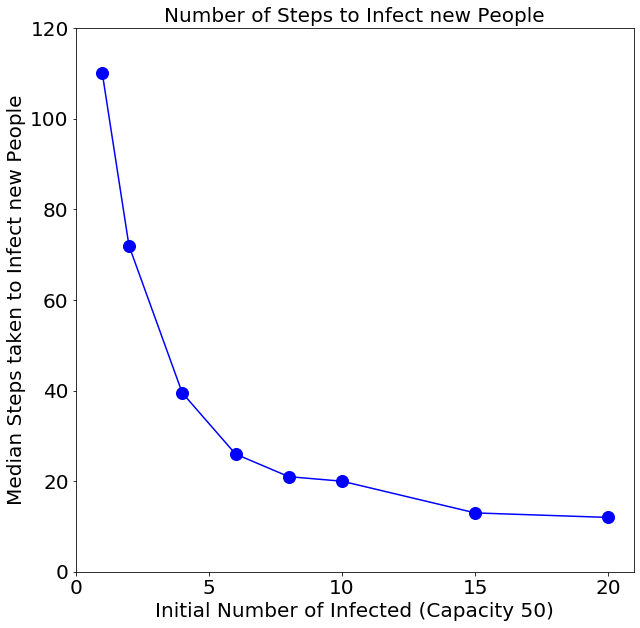

In [60]:
scatter_plot([new_infected_time_distribution_initial_all_mask_99], color_list=['b'], xticks_range=np.arange(0, 21, 5), yticks_range=np.arange(0, 121, 20), title="Number of Steps to Infect new People", x_title="Initial Number of Infected (Capacity 50)", y_title="Median Steps taken to Infect new People")

In [61]:
df = pd.read_csv('allmask99/numOfSickPeople/4/output0.csv')

df_temp = df[df['round'] == 0]
df_temp = df_temp[df_temp['id'] < 4][['row', 'col']]
affected_area_ordinate_list = list(zip(df_temp['row'], df_temp['col']))

df['color'] = df['isSick'].map(lambda x: 'red' if x else 'green')

for i in range(100):
    df_round = df[df['round']==i]
    snapShot(df_round, title='Round {}'.format(i), save_path='allmask99/numOfSickPeople/movie4/{}.jpg'.format(i), affected_area_ordinate_list=affected_area_ordinate_list)

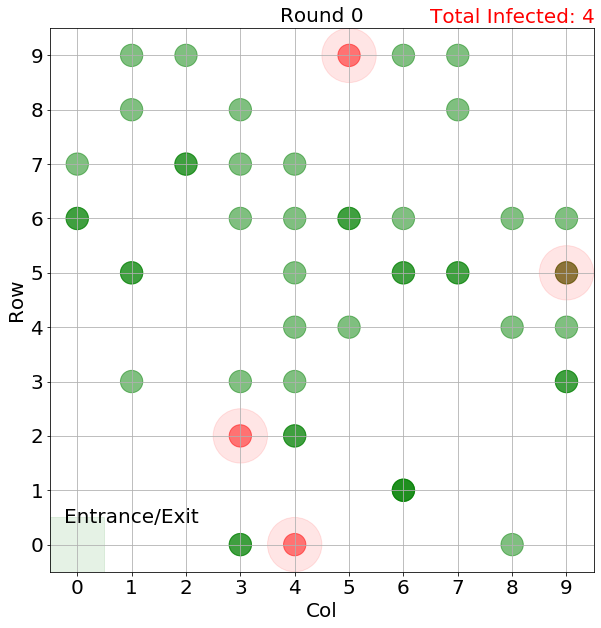

In [62]:
df_round = df[df['round']==0]
snapShot(df_round, title='Round 0', affected_area_ordinate_list=affected_area_ordinate_list)

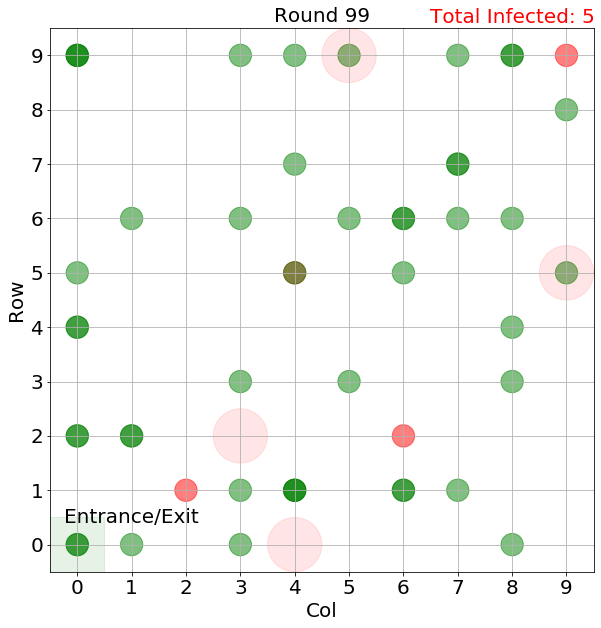

In [63]:
df_round = df[df['round']==99]
snapShot(df_round, title='Round 99', affected_area_ordinate_list=affected_area_ordinate_list)

# 6. Influence of Mask Wearing on Covid Spread
Herein, we compared the influence of mask wearing on total infected people vs. market capacity and initial number of infected people. We found that wearing mask can effectively reduce the Covid spread by at least 50%.

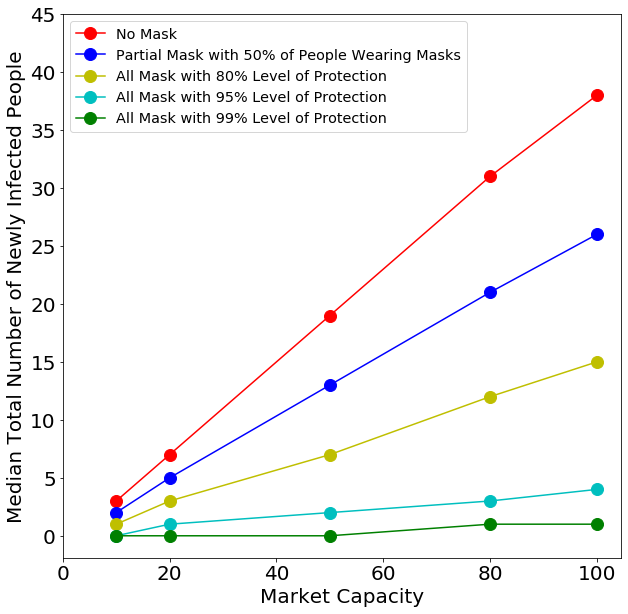

In [64]:
scatter_plot(dict_distribution_list=[num_of_new_infected_people_distribution, num_of_new_infected_people_distribution_partial_mask, num_of_new_infected_people_distribution_all_mask, num_of_new_infected_people_distribution_all_mask_95, num_of_new_infected_people_distribution_all_mask_99], color_list=['r','b','y', 'c', 'g'], xticks_range=np.arange(0, 101, 20), yticks_range=np.arange(0, 46, 5), title=None, x_title="Market Capacity", y_title="Median Total Number of Newly Infected People", label_list=["No Mask", "Partial Mask with 50% of People Wearing Masks", "All Mask with 80% Level of Protection", "All Mask with 95% Level of Protection", "All Mask with 99% Level of Protection"])

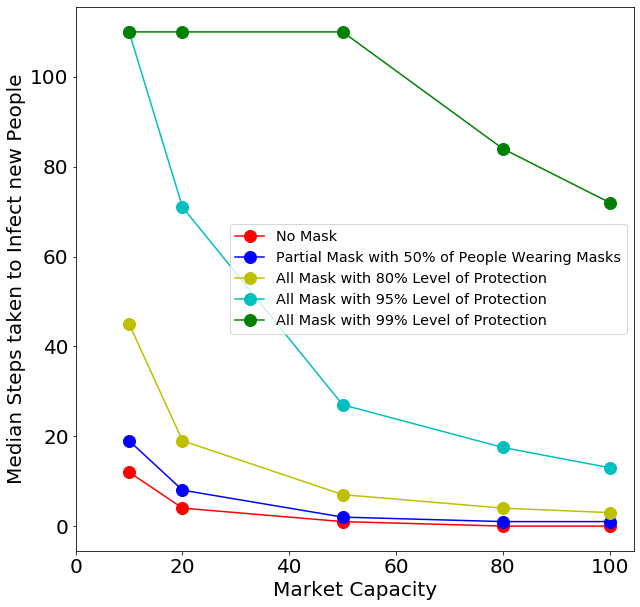

In [65]:
scatter_plot(dict_distribution_list=[new_infected_time_distribution, new_infected_time_distribution_partial_mask, new_infected_time_distribution_all_mask, new_infected_time_distribution_all_mask_95, new_infected_time_distribution_all_mask_99], color_list=['r','b','y', 'c', 'g'], xticks_range=np.arange(0, 101, 20), yticks_range=np.arange(0, 120, 20), title=None, x_title="Market Capacity", y_title="Median Steps taken to Infect new People", label_list=["No Mask", "Partial Mask with 50% of People Wearing Masks", "All Mask with 80% Level of Protection", "All Mask with 95% Level of Protection", "All Mask with 99% Level of Protection"])

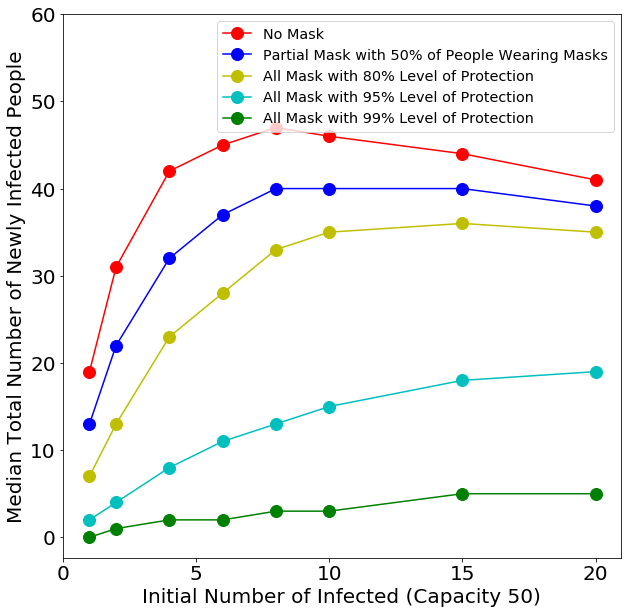

In [66]:
scatter_plot(dict_distribution_list=[num_of_new_infected_people_distribution_initial, num_of_new_infected_people_distribution_initial_partial_mask, num_of_new_infected_people_distribution_initial_all_mask, num_of_new_infected_people_distribution_initial_all_mask_95, num_of_new_infected_people_distribution_initial_all_mask_99], color_list=['r','b','y','c', 'g'], xticks_range=np.arange(0, 21, 5), yticks_range=np.arange(0, 70, 10), title=None, x_title="Initial Number of Infected (Capacity 50)", y_title="Median Total Number of Newly Infected People", label_list=["No Mask", "Partial Mask with 50% of People Wearing Masks", "All Mask with 80% Level of Protection", "All Mask with 95% Level of Protection", "All Mask with 99% Level of Protection"])

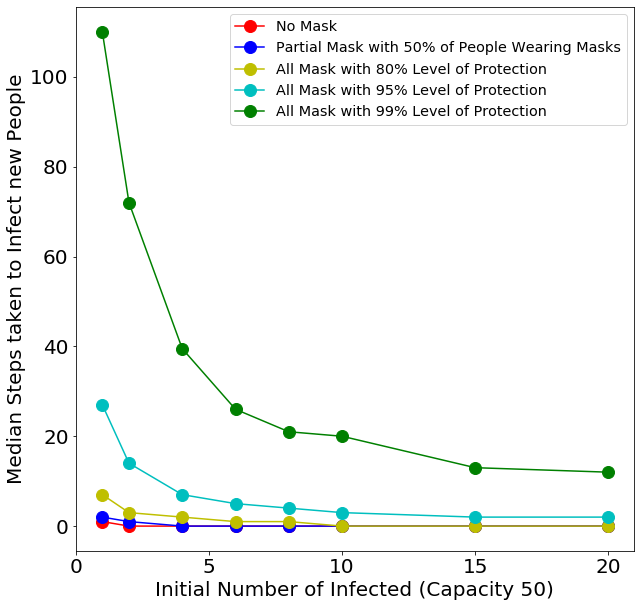

In [67]:
scatter_plot(dict_distribution_list=[new_infected_time_distribution_initial, new_infected_time_distribution_initial_partial_mask, new_infected_time_distribution_initial_all_mask, new_infected_time_distribution_initial_all_mask_95, new_infected_time_distribution_initial_all_mask_99], color_list=['r','b','y', 'c', 'g'], xticks_range=np.arange(0, 21, 5), yticks_range=np.arange(0, 120, 20), title=None, x_title="Initial Number of Infected (Capacity 50)", y_title="Median Steps taken to Infect new People", label_list=["No Mask", "Partial Mask with 50% of People Wearing Masks", "All Mask with 80% Level of Protection", "All Mask with 95% Level of Protection", "All Mask with 99% Level of Protection"])

In [68]:
# Save results to pickle files
with open('processed_data.pickle', 'wb') as f:
    pickle.dump([[num_of_new_infected_people_distribution, num_of_new_infected_people_distribution_partial_mask, num_of_new_infected_people_distribution_all_mask, num_of_new_infected_people_distribution_all_mask_95, num_of_new_infected_people_distribution_all_mask_99],
    [new_infected_time_distribution, new_infected_time_distribution_partial_mask, new_infected_time_distribution_all_mask, new_infected_time_distribution_all_mask_95, new_infected_time_distribution_all_mask_99],
    [num_of_new_infected_people_distribution_initial, num_of_new_infected_people_distribution_initial_partial_mask, num_of_new_infected_people_distribution_initial_all_mask, num_of_new_infected_people_distribution_initial_all_mask_95, num_of_new_infected_people_distribution_initial_all_mask_99],
    [new_infected_time_distribution_initial, new_infected_time_distribution_initial_partial_mask, new_infected_time_distribution_initial_all_mask, new_infected_time_distribution_initial_all_mask_95, new_infected_time_distribution_initial_all_mask_99]], f)

In [69]:
# Read pickle files into results
with open('processed_data.pickle', 'rb') as f:
    [[num_of_new_infected_people_distribution, num_of_new_infected_people_distribution_partial_mask, num_of_new_infected_people_distribution_all_mask, num_of_new_infected_people_distribution_all_mask_95, num_of_new_infected_people_distribution_all_mask_99],
    [new_infected_time_distribution, new_infected_time_distribution_partial_mask, new_infected_time_distribution_all_mask, new_infected_time_distribution_all_mask_95, new_infected_time_distribution_all_mask_99],
    [num_of_new_infected_people_distribution_initial, num_of_new_infected_people_distribution_initial_partial_mask, num_of_new_infected_people_distribution_initial_all_mask, num_of_new_infected_people_distribution_initial_all_mask_95, num_of_new_infected_people_distribution_initial_all_mask_99],
    [new_infected_time_distribution_initial, new_infected_time_distribution_initial_partial_mask, new_infected_time_distribution_initial_all_mask, new_infected_time_distribution_initial_all_mask_95, new_infected_time_distribution_initial_all_mask_99]] = pickle.load(f)

# 7. Convert Covid spread images into Video

In [70]:
def pic_to_video(path):
    """
    Convert a series of jpg pictures to movie
    """
    img_array = []

    for filename in sorted(glob(path + '*.jpg'), key = lambda x: int(re.findall('/(\d+).jpg', x)[0])):
        img = cv2.imread(filename)
        height, width, layers = img.shape
        size = (width,height)
        img_array.append(img) 

    out = cv2.VideoWriter(path + 'mask.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 1, size)

    for i in range(len(img_array)):
        out.write(img_array[i])

    out.release()